# Estimation-Maximization (EM) Algorithm

In [64]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Constants

In [65]:
N_GAUSSIANS = 5  # Number of Gaussian distributions.
N_SAMPLES = 1000  # Number of samples.
N_ITERATIONS = 100 # Number of EM iterations.

## 1. Dataset

Define helper functions.

In [66]:
def generateRandomCovarianceMatrix(n):
    """Generate a random covariance matrix.

    To generate a covariance matrix, we need to generate a random matrix Q, then
    Q @ Q.T would be a covariance matrix. This method works because Q @ Q.T has
    non-negative diagnonal elements, and it is symmetric and positive
    semidefinite.

    Args:
        n (int): number of dimensions.

    Return (numpy.ndarray ((n, n) & numpy.float64)): a random covariance matrix.
    """
    
    Q = np.random.default_rng().uniform(low=-1, high=1, size=(n, n))
    return Q @ Q.T

def multinoulli(p):
    """Draw one sample from a multinoulli distribution.

    Args:
        p (numpy.ndarray ((n,))): probability mass funtion.

    Return (int): an integer in [0, n) that represents a category.
    """

    # Retrieve the number of categories.
    n = p.shape[0]

    # Normalize the probabilities so that they sum to 1.
    p_normalized = p / p.sum()

    # Sampling.
    rn = np.random.default_rng().uniform(low=0, high=1)
    cummulated_mass = 0
    for i in range(n - 1):
        cummulated_mass += p_normalized[i]
        if rn < cummulated_mass:
            return i
    return n - 1

Generate the probabilities of selecting each Gaussian distribution.

In [67]:
# We sample in range [0.3, 1) to avoid an extremely small value.
# numpy.ndarray ((N_GAUSSIANS,) & numpy.float64)
p = np.random.default_rng().uniform(low=0.3, high=1, size=N_GAUSSIANS)

# Normalize the probabilities so that they sum to 1.
p /= p.sum()

Generate the means of Gaussian distributions.

In [68]:
# numpy.ndarray ((N_GAUSSIANS, 2) & numpy.float64)
means = np.random.default_rng().uniform(low=-5, high=5, size=(N_GAUSSIANS, 2))

Generate the covariance matrices of Gaussian distributions.

In [69]:
covs = []
for i in range(N_GAUSSIANS):
    covs.append(generateRandomCovarianceMatrix(2))

# numpy.ndarray ((N_GAUSSIANS, 2, 2) & numpy.float64)
covs = np.stack(covs)

Sample data points from Gaussian distributions.

In [70]:
points = []
indices = []

for i in range(N_SAMPLES):

    # Sample the index of Gaussian distributions.
    index = multinoulli(p)
    indices.append(index)

    # Sample a point using a specific Gaussian distribution.
    point = np.random.default_rng().multivariate_normal(mean=means[index], cov=covs[index])
    points.append(point)

# numpy.ndarray ((N_SAMPLES, 2) & numpy.float64)
points = np.stack(points)
# numpy.ndarray ((N_SAMPLES,) & numpy.int32)
indices = np.stack(indices)

Visualize data.

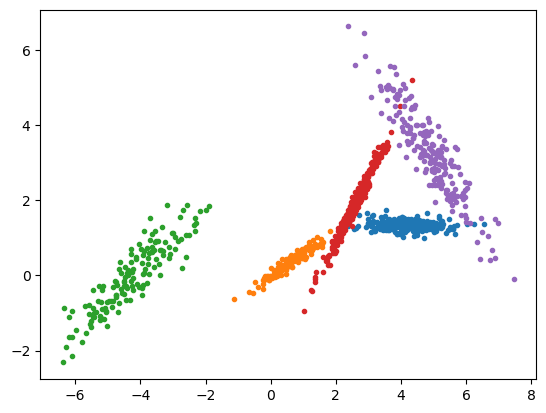

In [71]:
for i in range(N_GAUSSIANS):

    # Get all indices of a single Gaussian distribution.
    indices_single = [] # Indices for a single Gaussian distribution.
    for j in range(N_SAMPLES):
        if indices[j] == i:
            indices_single.append(j)

    plt.plot(points[indices_single,0], points[indices_single,1], '.')

plt.show()

## 2. Inference

Define helper functions.

In [115]:
def pdf(x, mean, cov):
    """Calculate the probability density function for multivariate Gaussian
    distributions.

    Args:
        x (numpy.ndarray ((n, d)))
        mean (numpy.ndarray ((d,))): mean of the Gaussian distribution.
        cov (numpy.ndarray ((d, d))): covariance matrix of the Gaussian
                                      distribution.

    Return (numpy.ndarray ((n,) & numpy.float64)): the probability density.
    """

    # Number of data points.
    n = x.shape[0]

    # Number of dimensions.
    d = x.shape[1]

    # Calculate the exponent.
    exponent = np.empty((n,)) # numpy.ndarray ((n,) & numpy.float64)
    for i in range(n):
        a = x[i][None, :] - mean
        exponent[i] = a @ np.linalg.inv(cov) @ a.T

    # Calculate the probability density.
    return 1 / (np.sqrt(np.power(2 * np.pi, d)) * np.linalg.det(cov)) * \
        np.power(np.e, -0.5 * exponent)

Randomly initialize the parameters.

In [72]:
p_inferred = np.random.default_rng().uniform(size=N_GAUSSIANS)
means_inferred = np.random.default_rng().uniform(size=(N_GAUSSIANS, 2))
covs_inferred = np.random.default_rng().uniform(size=(N_GAUSSIANS, 2, 2))